# Guided mode expansion with Autograd

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import time
import legume
import matplotlib as mpl

In [124]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Targetting modes in Photonic Crystal Cavity


In [125]:
# Number of PhC periods in x and y directions
Nx, Ny = 12, 12


# Regular PhC parameters
a=1.0

dslab = 0.26/0.366*a
n_slab = 3.4
ra = 0.344*a


# Initialize a lattice and PhC
lattice = legume.Lattice([Nx*a, 0], [0, Ny*np.sqrt(3)/2*a])

# Make x and y positions in one quadrant of the supercell
# We only initialize one quadrant because we want to shift the holes symmetrically
xp, yp = [], []
nx, ny = Nx, Ny
for iy in range(ny):
    for ix in range(nx):
        if iy == 0 and ix in (-1 %nx,0,1):
            continue
        if iy in (1,-1 % ny) and ix in (0, -1 % nx):
            continue
        xp.append((ix + (iy%2)*0.5)*a)
        yp.append((iy*np.sqrt(3)/2)*a)

nc = len(xp)

In [126]:
# Define L4/3 PhC cavity with shifted holes
def cavity():
    # Initialize PhC
    phc = legume.PhotCryst(lattice)

    # Add a layer to the PhC
    phc.add_layer(d=dslab, eps_b=n_slab**2)

    # Apply holes symmetrically in the four quadrants
    for ic, x in enumerate(xp):
        yc = yp[ic]
        xc = xp[ic]

        phc.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=ra))
    return phc

We will also define a function that initializes and runs a GME computation given shifts `dx`, `dy`, and returns the `gme` object and the quality factor of the fundamental cavity mode.

Let's first test the forward computation. Note that position shifts of the holes do not affect the average permittivity
of the slab that is used for the guided modes. Thus, setting the `gradients` option to `approx` actually still returns
the exact gradients, but is faster.

In [127]:
# Set some GME options
options = {'gmode_inds': [0 ], 'verbose': True, 'gradients': 'approx'}

# Initialize PhC
phc = cavity()

In [128]:
# For speed, we don't want to compute the loss rates of *all* modes that we store
options['compute_im'] = False
options['numeig']=75
options['eig_sigma']=0.32

# Initialize GME
gme = legume.GuidedModeExp(phc, gmax=1)

In [129]:
path=lattice.bz_path([[np.pi, 0],[0,0],[0, np.pi]], [3,3])
print(path["kpoints"])

[[3.14159265 2.0943951  1.04719755 0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         1.04719755 2.0943951
  3.14159265]]


In [130]:
# Solve:
gme.run(kpoints=np.array([[0],[0]]), **options)

grid = np.indices(np.shape(gme.freqs))


0.5105s total time for real part of frequencies, of which
  0.0470s for guided modes computation using the gmode_compute='exact' method
  0.0250s for inverse matrix of Fourier-space permittivity
  0.2730s for matrix diagionalization using the 'eigh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes


In [131]:
def modal_volume(minds, kinds, Nx=3, Ny=3):
    # Get the electric field in the center of the slab
    V = []
    for k in kinds:
        V.append([])
        for m in minds:
            e_y = gme.get_field_xy('e', kind=k, mind=m, z=dslab/2, component='y', Nx=Nx, Ny=Ny)[0]['y']
            e_x = gme.get_field_xy('e', kind=k, mind=m, z=dslab/2, component='x', Nx=Nx, Ny=Ny)[0]['x']
            e_abs=(e_x**2+e_y**2)**(1/2)
            V[k].append(1/np.square(np.max(np.abs(e_abs[int(0.25*Nx):-int(0.25*Nx),int(0.25*Ny):-int(0.25*Ny)]))))
    # Notice the use of autograd.numpy (npa) and not plain numpy (np)
    return np.array(V)

def of_V():
    # Get the electric field in the center of the slab
    Ey = gme.get_field_xy('e', kind=0, mind=0, z=dslab/2, component='y', Nx=3, Ny=3)[0]['y']
    ney=np.linalg.norm(Ey)
    # Notice the use of autograd.numpy (npa) and not plain numpy (np)
    return 1/np.square(np.amax(np.abs(Ey)))

kinds = range(np.shape(grid)[1])
minds = range(np.shape(grid)[2])
V = modal_volume(minds, [0], Nx=25, Ny=25)

230.39163770709192


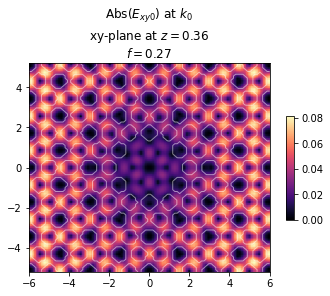

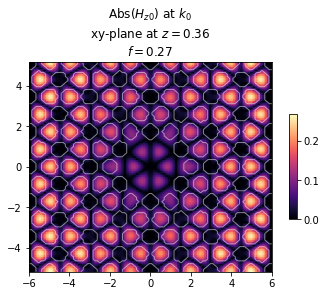

In [132]:
legume.viz.field(gme,'E', 0, 0,z=dslab/2, component='xy', val='abs', N1=100, N2=100, norm=True)
legume.viz.field(gme,'H', 0, 0,z=dslab/2, component='z', val='abs', N1=100, N2=100, norm=True)
print(V[0][0])

In [133]:
# flat_freq=np.sort(gme.freqs.flatten())
# freq_diff = np.diff(flat_freq)


In [134]:

# V_arg= np.argsort(V[0])
#
#
#

In [135]:
# freqs_im, _, _ = gme.compute_rad(0, V_arg[range(30)])
#
#

In [136]:
# Q = gme.freqs[0][V_arg[0:30]]/2/freqs_im
#
# Q_arg=np.argsort(Q)[::-1]
# V_arg= np.argsort(V[0])[::-1]
# for i in Q_arg:
#     fig=legume.viz.field(gme,'E', 0, V_arg[i],z=dslab/2, component='xy', val='abs', N1=100, N2=100, norm=True)
#     fig.text(0.5,-0.25,"arg: " + str(V_arg[i])+ "\n"
#              + "freq: " + str(gme.freqs[0][V_arg[i]]) + "\n"
#              + "Volume: " + str(V[0][V_arg[i]]) + "\n"
#              + "Q: " + str(Q[i]))
#

In [137]:
# M = gme._construct_mat(0)